<center><img src='https://i.ytimg.com/vi/WP4F6aK1Ft8/maxresdefault.jpg' size ='400px'></center>

### ***PURPOSE***<br>
<tab>So why do i am presenting this notebook.just to contribute to the comunity.Today i was studing about how does the yolov3 works and i was doing some of the PoCs on how to implement and use yolov3 on my project to complete certain task.So this notebook is one result of 3 PoCs that i have done today and i think that i should show and get your feedback on this. I also believe that this notebook might help you in some way or it might be a source from where anyone could take insperation and use it to increase their understanding......<br>
if you get some insperation you can use it in [this competition](https://www.kaggle.com/c/global-wheat-detection)

<font color="red" size=3>Please UPVOTE this kernel if you like it. It motivates me to produce more quality content :) <br><br>
    Please do comment what your views are and what you understand from this.
    <br><br> Dont't forget to give your suggestions in the comment section </font>

**So why yolov3 not any other**<br>
### 1. RCNN

from last 5 years we have found leaps and bound growth in the object detection since the famous rcnn paper(https://arxiv.org/pdf/1311.2524.pdf)
![see](https://cv-tricks.com/wp-content/uploads/2017/12/RCNN-e1514378306435.jpg)
#### Selective Search:
    1. Generate initial sub-segmentation, we generate many candidate regions
    2. Use greedy algorithm to recursively combine similar regions into larger ones 
    3. Use the generated regions to produce the final candidate region proposals <br>
these region proposals are then sent to a cnn model like vgg or resnet and than a svm is used to classify the category and a bounding box regeressor <br>
#### Problems:
    1. It cannot be implemented real time as it takes around 40 seconds for each test image.
    2. no learning is happening at the selective search algorithm stage Therefore, no learning is happening at that stage. This could lead to the generation of bad candidate region proposals.

### 2. **Spatial Pyramid Pooling(SPP-net)**

1. so to tackle the rcnn slow process in this SPP-Net we calculate the CNN representation for entire image only once and can use that to calculate the CNN representation for each patch generated by Selective Search. This can be done by performing a pooling type of operation on JUST that section of the feature maps of last conv layer that corresponds to the region. this leads to significant difference in the execution and training time 
2. generate the fixed size of input for the fully connected layers of the CNN so, SPP introduces one more trick. It uses spatial pooling after the last convolutional layer as opposed to traditionally used max-pooling.
    
With SPP, we don’t need to crop the image to fixed size, like AlexNet, before going into CNN. Any image sizes can be inputted.
![see](https://miro.medium.com/max/1400/1*n4LE9idyGJX_efOsS-FNvw.png)
after these features are passes to Three-Level Spatial Pyramid Pooling (SPP) in SPPNet with Pyramid {4×4, 2×2, 1×1}. which inturn leads to svm for classification and bounding box 


### 3. **Fast R-CNN**

1. The reason “Fast R-CNN” is faster than R-CNN is because you don’t have to feed 2000 region proposals to the convolutional neural network every time. Instead, the model has a ROI layer this RoI pooling layer turn the regions into a fixed size so that it can be fed into a fully connected layer. From the RoI feature vector, we use a softmax layer to predict the class of the proposed region and also the offset values for the bounding box.
2. instead of feeding the region proposals to the CNN, we feed the input image to the CNN to generate a convolutional feature map. From the convolutional feature map adapted from the spp-net this reduces the need of repeatedly proposing the features 
3. this created first model with end-to-end learning strategy
    
![](https://miro.medium.com/max/1400/1*TDOx63GthXwgXJb3hXUsUQ.png)

### 4. **Faster RCNN**

1. the above algorithms(R-CNN & Fast R-CNN) uses selective search to find out the region proposals. Selective search is a slow and time-consuming process affecting the performance of the network.
2. Faster RCNN replaces selective search with a very small convolutional network called Region Proposal Network to generate regions of Interests.
3. To handle the variations in aspect ratio and scale of objects, Faster R-CNN introduces the idea of anchor boxes. At each location, the original paper uses 3 kinds of anchor boxes for scale 128x 128, 256×256 and 512×512. Similarly, for aspect ratio, it uses three aspect ratios 1:1, 2:1 and 1:2. 
4. RPN gives out bounding boxes of various sizes with the corresponding probabilities of each class. The varying sizes of bounding boxes can be passed further by apply Spatial Pooling just like Fast-RCNN

![](https://miro.medium.com/max/1400/1*pSnVmJCyQIRKHDPt3cfnXA.png) 

### 5. **YOLO**
1. In YOLO detection is a simple regression problem which takes an input image and learns the class probabilities and bounding box coordinates
2. Though it is no longer the most accurate object detection algorithm, it is a very good choice when you need real-time detection, without loss of too much accuracy.
3.  YOLO divides each image into a grid of S x S and each grid predicts N bounding boxes and confidence. The confidence reflects the accuracy of the bounding box and whether the bounding box actually contains an object(regardless of class). YOLO also predicts the classification score for each box for every class in training. You can combine both the classes to calculate the probability of each class being present in a predicted box.
4. Notice that at runtime, we have run our image on CNN only once. Hence, YOLO is super fast and can be run real time. Another key difference is that YOLO sees the complete image at once as opposed to looking at only a generated region proposals in the previous methods

![](https://cv-tricks.com/wp-content/uploads/2017/12/model2-1024x280.jpg)    

#### But still th e question remains why yolov3
   1. For the task of detection,it has 106 layer fully convolutional underlying architecture making it slower but also improving the accuracy or (MAP) for the detection
   2. The most salient feature of v3 is that it makes detections at three different scales.
   3. Better at detecting smaller objects as The upsampled layers concatenated with the previous layers help preserve the fine grained features which help in detecting small objects.
   4. It predicts boxes at 3 different scales. For the same image it predicts 10x the number of boxes predicted by YOLO v2
   5. No more softmaxing the classes as its requirement is to have mutually exclusive classes but different objects might have some relation between them which could not be independent
   
![](https://image.slidesharecdn.com/pr12yolov3-191117141544/95/pr207-yolov3-an-incremental-improvement-13-638.jpg?cb=1574001871)

### ***STRATING THE GAME***

In [20]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import imageio
import sys
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import cv2
import math
import os
from PIL import Image 

from dehaze import*

In [21]:
# create a YOLOv3 Keras model and save it to file
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) 
        x = Conv2D(conv['filter'],
                    conv['kernel'],
                    strides=conv['stride'],
                    padding='valid' if conv['stride'] > 1 else 'same',
                    name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                                 {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                                 {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                                 {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                                 {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                                {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model
model = make_yolov3_model()
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


**The above model approach clearly shows that how is the architecture of the yolov3 model  **<br>
Reading the weights of the v3 model

In [22]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,	= struct.unpack('i', w_f.read(4))
            minor,	= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) 
                    gamma = self.read_bytes(size) 
                    mean  = self.read_bytes(size) 
                    var   = self.read_bytes(size) 
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

model = make_yolov3_model()
weight_reader = WeightReader("D:\\lane_detection_and vehicle _detection\\yolov3.weights")
weight_reader.load_weights(model)
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

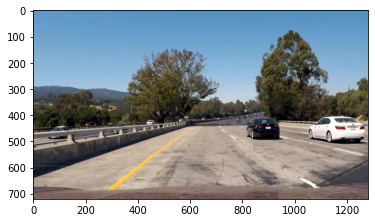

In [23]:
i1="D:\\lane_detection_and vehicle _detection\\image\\test1.jpg"
img = mpimg.imread(i1)
plt.imshow(img)
plt.show()

**Here I will show how i am detecting the lanes using cv2's canny edge and HoughLinesP**
### 1. **Canny Edge detection**<br>
The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works. (Wikipedia)
first we will apply gaussian blur to remove the noise then we will use to find the magnitude and slope of the gradient with the help os sober filters we will have edges with high and low intensity . non max supresstion is then used on these intensities which supresses the small of low intensity edges leading us to have only high intensity edge . then the still remaining weak pixels are than converted to strong pixels only is they have strong pixels near them else they are finally supressed.

![](https://scikit-image.org/docs/0.5/_images/plot_canny_1.png)
### 2. ** HoughLinesProbablistic**<br>
Hough transform is a feature extraction method for detecting simple shapes such as circles, lines etc in an image. first we create an accumulater which we can think of a 2D array which then we will fill this array with the edges pixels no we incrementally select and update the accumulater with edge interaction pixels leading us to fill up the whole 2D matrix through which We can simply select the bins in the accumulator above a certain threshold to find the lines in the image. If the threshold is higher, you will find fewer strong lines, and if it is lower, you will find a large number of lines including some weak ones

![](https://scikit-image.org/docs/0.11.x/_images/plot_line_hough_transform_2.png)

In [49]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=5):
    if lines is None:
        return 
    img = np.copy(img) 
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)    
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0) 
    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """ 
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
#             if(x2-x1==0):
#                 continue
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5: 
                continue
            if slope <= 0: 
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: 
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2]) 
    min_y = int(image.shape[0] * (3 / 5)) 
    max_y = int(image.shape[0])
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
    
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
#     right_x_start = 0
#     right_x_end = 0
    
    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )    
    pts = np.array([[left_x_start, max_y],[left_x_end, min_y],[right_x_start, max_y],
                    [right_x_end, min_y]], np.int32)
    return line_image,pts

In [50]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    """ 
        This is the inference part of yolo outputs as is take predefined
        anchors and netoutput which is a list of 106th,82th,86th layers
        
    """
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w 
            y = (row + y) / grid_h 
            w = anchors[2 * b + 0] * np.exp(w) / net_w 
            h = anchors[2 * b + 1] * np.exp(h) / net_h 
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

                    
def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = np.expand_dims(image, 0)
    return image, width, height


def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores

def draw_boxes(filename, v_boxes, v_labels, v_scores,pshow,pipeline):
    q,pts=pipeline(pshow)
    
    pts = pts.reshape((-1,1,2))
    cv2.fillPoly(q,[pts],(0,0,255))
    plt.imshow(q)
    ax = plt.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        #w, h = x2 - x1, y2 - y1
        q=cv2.rectangle(q, (x1, y1), (x2, y2), (255,255,255), 3)
        #rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        #ax.add_patch(rect)
        label = "%s" % (v_labels[i])
        #plt.text(x1, y1, label, color='white')
        q = cv2.putText(q, label, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (255,255,255), 2, cv2.LINE_AA)
   
    #image = mpimg.imread(i2)
#     plt.imsave(filename,q)
#     plt.axis('off')
#     plt.savefig('out.png',bbox_inches='tight',pad_inches=0)
#     i2="D:\\Machine_Learning__\\vehicle-detection-master\\out.png"
    
    
    return q
    
model = keras.models.load_model("D:\\lane_detection_and vehicle _detection\\model.h5")

<IPython.core.display.Javascript object>

### **Non Max Supression**
![](https://lilianweng.github.io/lil-log/assets/images/non-max-suppression.png)

This algorithms can be simply expained as first we select a proposal with highest confidence score, remove it from B and add it to the final proposal in to a new list D. Now compare this proposal with all the proposals and then we will calculate the IOU of this proposal with every other proposal. If the IOU is greater than the threshold N, remove that proposal from B.Again take the proposal with the highest confidence from the remaining proposals in B and remove it from B and add it to D.Once again calculate the IOU of this proposal with all the proposals in B and eliminate the boxes which have high IOU than threshold.This process is repeated until there are no more proposals left in B.

### **compute** == **"Main Function"**

In [51]:
def compute(photo_filename,img,pipeline):
    
    input_w, input_h = 416,416
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    class_threshold = 0.6
    
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    
    if type(photo_filename)==str:
        image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    else:
        image= cv2.resize(photo_filename, (input_w, input_h))
        image_w,image_h=image.shape[1],image.shape[0]
        image=np.expand_dims(image,axis=0)
        
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    do_nms(boxes, 0.5)
    
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    return draw_boxes(photo_filename, v_boxes, v_labels, v_scores,img,pipeline)
    #img.save(os.path.join("out", img), quality=90)

### **RUN IT ALL**

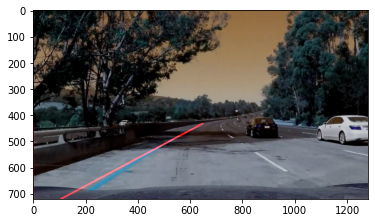

In [58]:
i2="D:\\lane_detection_and vehicle _detection\\image\\test5.jpg"
img2 = cv2.imread(i2)
img,pts=pipeline(img2)
# res=compute('image\\test5.jpg',img2,pipeline)
res= cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [40]:
img2.shape


dtype('uint8')

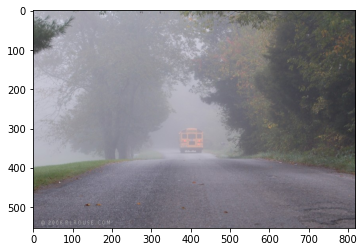

In [10]:
plt.imshow(plt.imread("D:\\lane_detection_and vehicle _detection\\hazy_Images\\foggy-school-morning.jpg"))

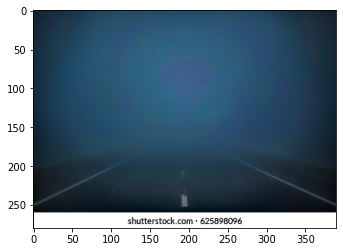

In [56]:
def fun(img):
    src = cv2.imread(img);
    I = src.astype('float64')/255;

    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2.imwrite("./image/k.png",J*255);
    img2=cv2.imread("./image/k.png");
    return img2
#src=cv2.imread("D:\\lane_detection_and vehicle _detection\\hazy_Images\\foggy-school-morning.jpg")
r=fun("D:\\lane_detection_and vehicle _detection\\hazy_Images\\misty-road-260nw-625898096.jpg")
r= cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
plt.imshow(r)


Sat Jan 22 00:23:51 2022
True


TypeError: expected non-empty vector for x

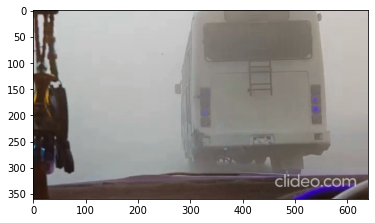

In [117]:
import time
print (time.asctime( time.localtime(time.time()) ))
cap = cv2.VideoCapture("D:\\lane_detection_and vehicle _detection\\image\\WhatsApp Video 2022-01-16 at 00.11.43.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc(*'MJPG'),10,size)
print(cap.isOpened())
while(cap.isOpened()):
    ret,frame = cap.read()
    cv2.imwrite('frame.jpg',frame)
    #img3=cv2.imread("frame.jpg")
    if ret==True:
        #img3=fun("D:\\lane_detection_and vehicle _detection\\image\\frame.jpg")
        #img3= cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
        plt.imshow(img3)
        img3=compute("frame.jpg",frame,pipeline)
        out.write(img3)
cap.release()
print (time.asctime( time.localtime(time.time()) ))

In [57]:
i4="D:\\lane_detection_and vehicle _detection\\image\\k.png"
#cv2.imread(i4, cv2.IMREAD_COLOR).dtype 
img4 = cv2.imread(i4)
#img,pts=pipeline(img2)
#img4 = cv2.resize(img4, (416, 416))
res1=compute(i4,img4,pipeline)
res1= cv2.cvtColor(res1, cv2.COLOR_BGR2RGB)
plt.imshow(res1)


TypeError: expected non-empty vector for x

In [119]:
import time
print (time.asctime( time.localtime(time.time()) ))
cap = cv2.VideoCapture("D:\\lane_detection_and vehicle _detection\\image\\WhatsApp Video 2022-01-16 at 00.11.43.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc(*'MJPG'),10,size)
print(cap.isOpened())
while(cap.isOpened()):
    ret,frame = cap.read()
    cv2.imwrite('1.jpg',frame)
    if ret==True:
        a=compute('1.jpg',frame,pipeline)
        out.write(a)
    else:
        break
cap.release()
print (time.asctime( time.localtime(time.time()) ))

Sat Jan 22 00:27:41 2022
True


TypeError: expected non-empty vector for x

### ***References***
1. https://lilianweng.github.io this is very informative page in all terms seriously i have learn a lot of things it
2. I might have left the concept of [mAP](https://datascience.stackexchange.com/questions/25119/how-to-calculate-map-for-detection-task-for-the-pascal-voc-challenge) so please visit this question and answer pair on stackoverflow
3. If you want to implement yolo from scratch in pytorch you can visit https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/ man this is good 
4. Want to deeply analyze the benchmarks see https://medium.com/@jonathan_hui/object-detection-speed-and-accuracy-comparison-faster-r-cnn-r-fcn-ssd-and-yolo-5425656ae359 i don't know anything better than this post interms of object detection benchmarking
5. Also i Have not touched the bounding box regression very deeply in Yolo so keen learners can visit http://christopher5106.github.io/object/detectors/2017/08/10/bounding-box-object-detectors-understanding-yolo.html
6. https://navoshta.com/detecting-road-features/ goto blogpost if you are interested in self-driving or road-features
7. In the end you can visit https://www.kaggle.com/ because i think this is also a ""goood"" site.

### ***ENDNOTE***


I just want to say thankyou for other unknown kagglers and people that provide information they accuired from any where and share it keeping the free flow of knowledge alive respect++<br>


**CHRONOLOGY samaj lijiye**
![](https://pbs.twimg.com/media/DwJmqj1V4AEcLvA?format=jpg&name=small)


If you like this tutorial on how to use yolo with opencv please <font color="red" size=3> UPVOTE</font>because
![](https://media3.giphy.com/media/SnAXCQTYU4Awg/200.webp?cid=ecf05e47733219bb765a346445787ebe7b41c48d22cc7d8d&rid=200.webp)
